## Pre processing

In [49]:
import pandas as pd
import openml
import numpy as np

In [50]:
dataset = openml.datasets.get_dataset(46859)
df, *_ = dataset.get_data()

In [51]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, stratify=df["TARGET"], random_state=666)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, stratify=df_full_train["TARGET"], random_state=666)

y_train = df_train.TARGET
y_val = df_val.TARGET
y_test = df_test.TARGET

df_train = df_train.drop(columns=["TARGET"])
df_val = df_val.drop(columns=["TARGET"])
df_test = df_test.drop(columns=["TARGET"])

X_train = df_train.values
X_val = df_val.values
X_test = df_test.values

## XGBoost

In [52]:
import xgboost as xgb

In [53]:
features = df_train.columns.tolist()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [54]:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    cols = ['num_iteration', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns = cols)
    return df_results



In [55]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

KeyboardInterrupt: 

In [ ]:
df_score = parse_xgb_output(output)

In [ ]:
from matplotlib import pyplot as plt

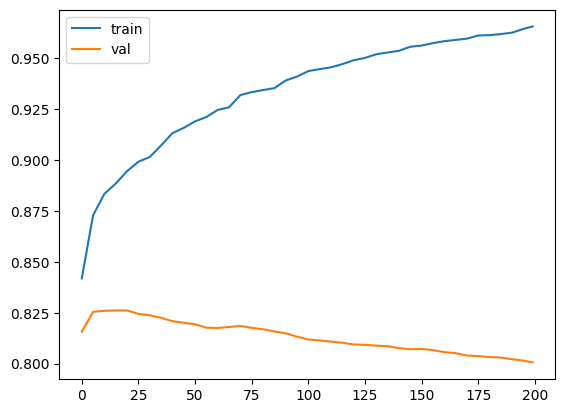

In [ ]:
plt.plot(df_score.num_iteration, df_score.train_auc, label='train')
plt.plot(df_score.num_iteration, df_score.val_auc, label='val')
plt.legend()

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

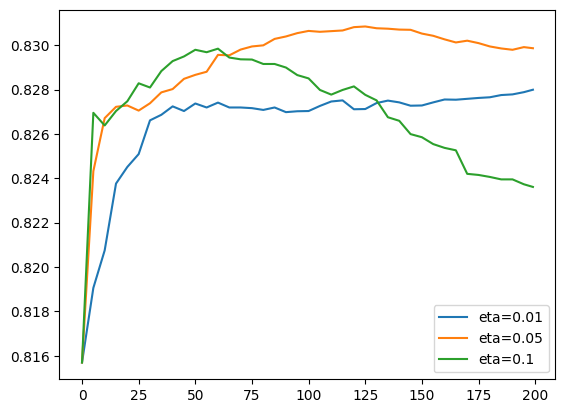

In [ ]:
etas = ['eta=0.01', 'eta=0.05', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iteration, df_score.val_auc, label=eta)
plt.legend()

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

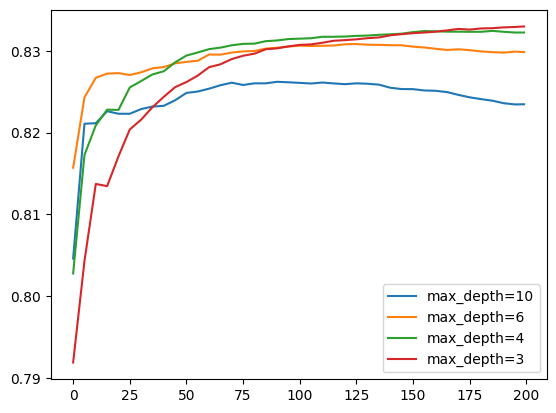

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iteration, df_score.val_auc, label=max_depth)
plt.legend()

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

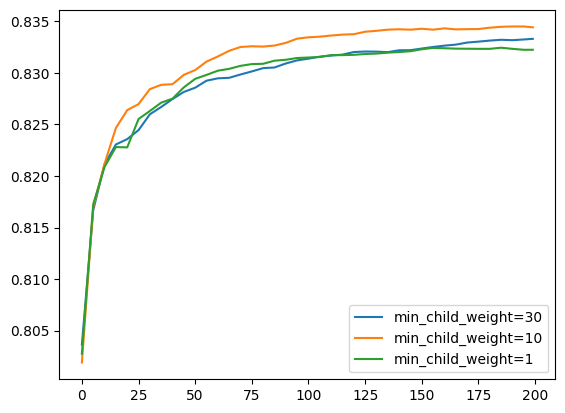

In [ ]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iteration, df_score.val_auc, label=min_child_weight)
plt.legend()

In [56]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=130, verbose_eval=5, evals=watchlist)

In [59]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8340619498261967

## Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [60]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

for a in alphas:
    ridge = Ridge(alpha=a)
    auc = cross_val_score(ridge, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    print(f"alpha={a:.5f}  AUC={auc:.4f}")

/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

alpha=0.00010  AUC=nan


/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

alpha=0.00100  AUC=nan


/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

alpha=0.01000  AUC=nan


/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

alpha=0.10000  AUC=nan


/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

alpha=1.00000  AUC=nan


/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

alpha=10.00000  AUC=nan


/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sk

In [ ]:
model = LogisticRegression(random_state=666, class_weight='balanced', max_iter=10000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

In [ ]:
scores = []

for r in [0.0, 0.00001, 0.001, 0.1, 1, 10]:
    model = LogisticRegression(C=r,
                               random_state=666,
                               class_weight='balanced', 
                               max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((r, auc))

df_scores = pd.DataFrame(scores, columns=['regularization', 'auc'])

plt.plot(df_scores.regularization, df_scores.auc)
plt.plot()

/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,666
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]

In [110]:
roc_auc_score(y_val, y_pred)

0.6548507326853237

## Decision Trees

In [115]:
from sklearn.tree import DecisionTreeClassifier

In [119]:
scores =[]
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d,s, auc))

In [129]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])

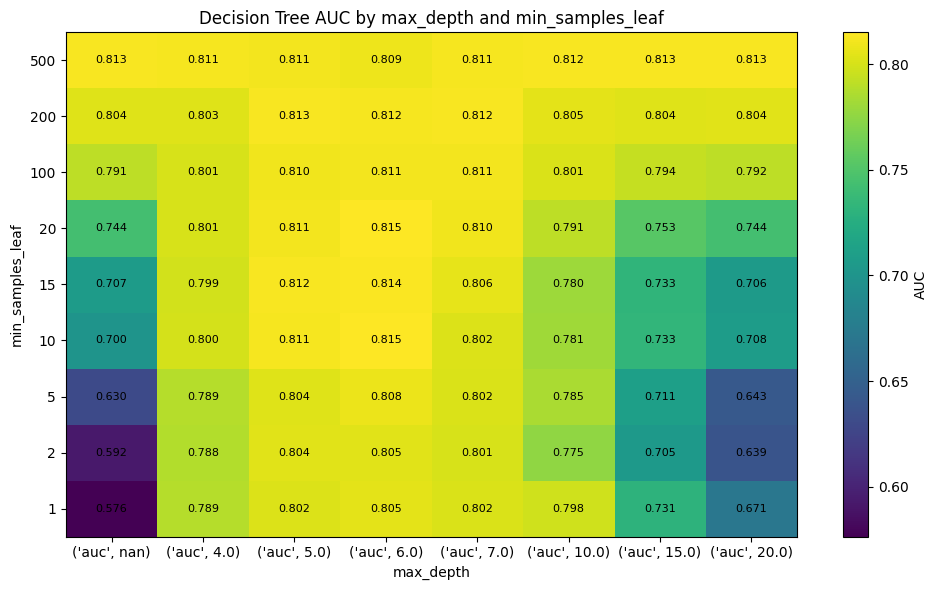

In [125]:
plt.figure(figsize=(10, 6))
plt.imshow(df_scores_pivot, cmap="viridis", aspect="auto", origin="lower")
plt.colorbar(label="AUC")
plt.title("Decision Tree AUC by max_depth and min_samples_leaf")
plt.xticks(ticks=range(len(df_scores_pivot.columns)),
           labels=df_scores_pivot.columns)
plt.yticks(ticks=range(len(df_scores_pivot.index)),
           labels=df_scores_pivot.index)
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
for i in range(len(df_scores_pivot.index)):
    for j in range(len(df_scores_pivot.columns)):
        value = df_scores_pivot.iloc[i, j]
        if not np.isnan(value):
            plt.text(j, i, f"{value:.3f}", ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()


In [128]:
model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8135404243081434

## Random Forest

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
rf = RandomForestClassifier(n_estimators=10, random_state=666)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [132]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6740777215700211

In [134]:
scores =[]

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=666, n_jobs=-1)
    rf.fit(X_train, y_train) 

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

[]

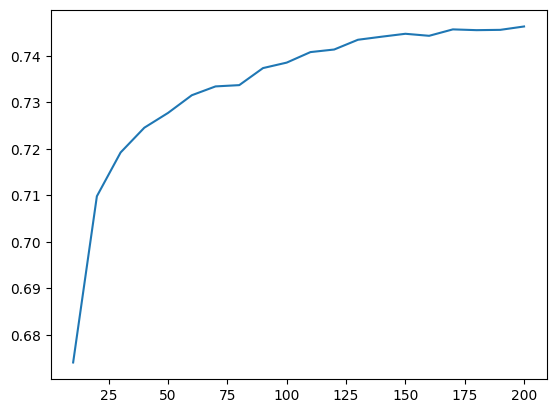

In [136]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.plot()

In [138]:
scores =[]

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=666, n_jobs=-1)
        rf.fit(X_train, y_train) 

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

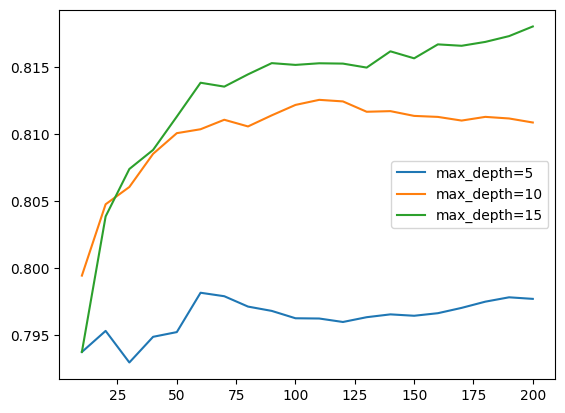

In [140]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

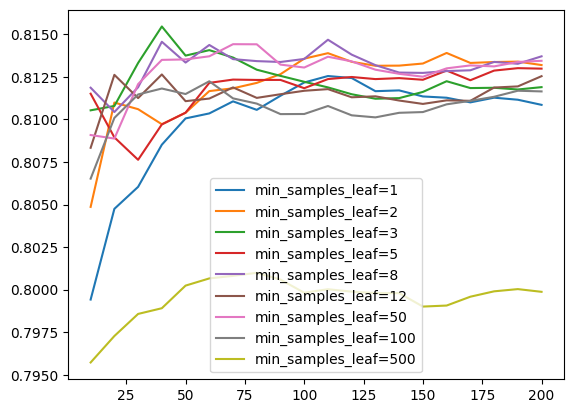

In [ ]:
max_depth=10
scores = []
samples = [1, 2, 3, 5, 8, 12, 50, 100, 500]
n_estimators = 200

for s in samples:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth, 
                                    min_samples_leaf=s, 
                                    random_state=666, 
                                    n_jobs=-1)
        rf.fit(X_train, y_train) 

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])

for s in samples:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, 
            label='min_samples_leaf=%s' % s)

plt.legend()

In [149]:
max_depth=10
n_estimators = 200
min_samples_leaf = 8

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10, 
                            min_samples_leaf=8, 
                            random_state=666, 
                            n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Selecting the best model

In [ ]:
model = LogisticRegression(random_state=666, class_weight='balanced', max_iter=10000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

/Users/djsruptorlytics/SharedProjects/Santander-customer-satisfaction-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13801 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6436939075837698

In [151]:
model = DecisionTreeClassifier(max_depth=6,
                               min_samples_leaf=10)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.814728538074018

In [152]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10, 
                            min_samples_leaf=8, 
                            random_state=666, 
                            n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8137087328409478